# YOLOv11 Landmark Detection - Data Preparation & Balancing

This notebook provides focused data preparation for landmark detection training, emphasizing realistic and balanced datasets.

## Table of Contents
1. [Setup & Import Libraries](#1-setup--import-libraries)
2. [Dataset Verification & Analysis](#2-dataset-verification--analysis)
3. [Sample Visualization & Quality Check](#3-sample-visualization--quality-check)
4. [Balanced Data Augmentation](#4-balanced-data-augmentation)
5. [Final Dataset Creation for Training](#5-final-dataset-creation-for-training)

**Focus**: Create a balanced, realistic dataset optimized for landmark detection training.

---

---
## 1. Setup & Import Libraries

Install required packages and import all necessary libraries for data processing and landmark detection.

In [1]:
%pip install ultralytics
%pip install opencv-python
%pip install pillow
%pip install matplotlib
%pip install seaborn
%pip install tensorboard
%pip install albumentations
%pip install pyyaml
%pip install tensorflow
%pip install tensorflow-lite

print("All packages installed successfully!")

  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxslim 0.1.71 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.
tensorflow-intel 2.17.0 requires ml-dtypes<0.5.0,>=0.3.1, but you have ml-dtypes 0.5.3 which is incompatible.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 6.33.0 which is incompatible.
tensorflow-intel 2.17.0 requires tensorboard<2.18,>=2.17, but you have tensorboard 2.20.0 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

ERROR: Could not find a version that satisfies the requirement tensorflow-lite (from versions: none)
ERROR: No matching distribution found for tensorflow-lite


---
## 2. Dataset Verification & Analysis

Verify dataset integrity and analyze class distribution to understand imbalance issues that need to be addressed.

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
import shutil
import yaml
from collections import Counter
import albumentations as A
from PIL import Image
import random
import json
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 3. Dataset Configuration & Verification

Set up dataset paths and verify the integrity of the dataset structure. This includes:
- Checking if dataset directories exist
- Counting images and labels
- Verifying image-label synchronization
- Loading class definitions and dataset notes

Dataset path: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages
Images directory: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\images
Labels directory: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\labels

Dataset verification:
  Total images: 1044 (JPG: 1012, JPEG: 28, PNG: 4)
  Total labels: 1044
  Perfect sync: Images and labels match

Landmark classes (4 total):
  0: ArtScience Museum
  1: Esplanade
  2: Marina Bay Sands
  3: Merlion

CLASS DISTRIBUTION ANALYSIS:
  Total annotated objects: 1499

Class imbalance details:
  MAJORITY Class 0 (ArtScience Museum):  459 objects ( 30.6%) - 1.2x
  MINORITY Class 1 (Esplanade):  174 objects ( 11.6%) - 3.3x
  MAJORITY Class 2 (Marina Bay Sands):  570 objects ( 38.0%) - 1.0x
  BALANCED Class 3 (Merlion):  296 objects ( 19.7%) - 1.9x

Overall imbalance ratio: 3.28x (max/min)
  SEVERE imbalance detected - balancing required


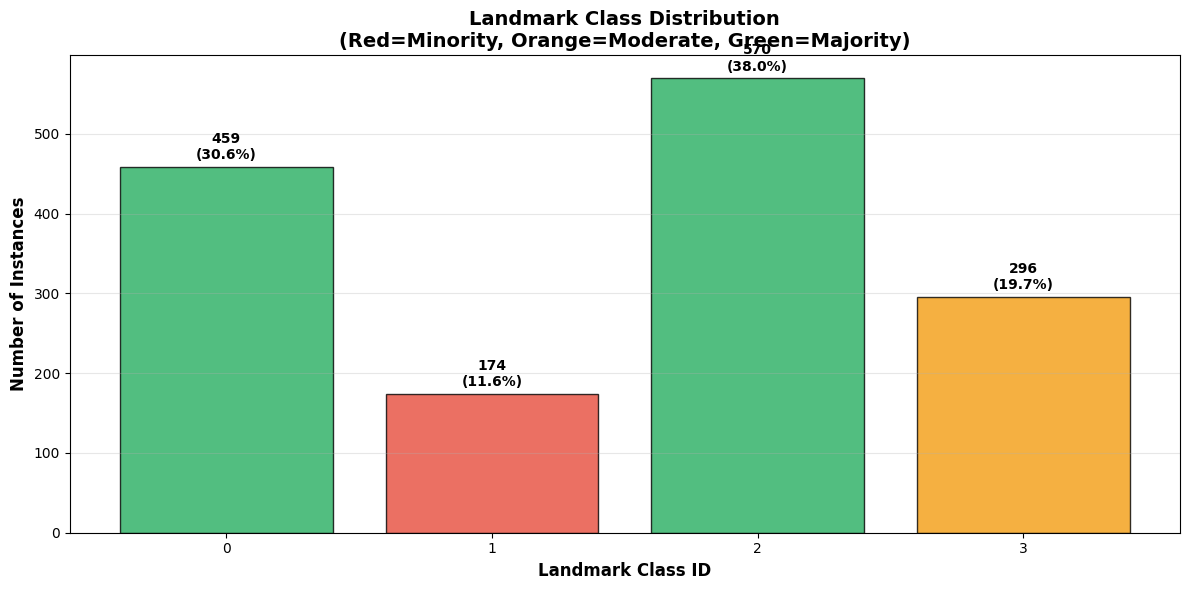


Dataset verification and analysis complete!


In [ ]:
# Dataset Verification & Class Distribution Analysis
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

# Dataset paths
DATASET_PATH = Path(r"D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages")
IMAGES_DIR = DATASET_PATH / "images"
LABELS_DIR = DATASET_PATH / "labels"
CLASSES_FILE = DATASET_PATH / "classes.txt"
NOTES_FILE = DATASET_PATH / "notes.json"

print(f"Dataset path: {DATASET_PATH}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Labels directory: {LABELS_DIR}")

# Verify dataset exists
assert IMAGES_DIR.exists(), f"Images directory not found: {IMAGES_DIR}"
assert LABELS_DIR.exists(), f"Labels directory not found: {LABELS_DIR}"

# Count images (all formats)
num_jpg = len(list(IMAGES_DIR.glob("*.jpg")))
num_jpeg = len(list(IMAGES_DIR.glob("*.jpeg")))
num_png = len(list(IMAGES_DIR.glob("*.png")))
num_images = num_jpg + num_jpeg + num_png
num_labels = len(list(LABELS_DIR.glob("*.txt")))

print(f"\nDataset verification:")
print(f"  Total images: {num_images} (JPG: {num_jpg}, JPEG: {num_jpeg}, PNG: {num_png})")
print(f"  Total labels: {num_labels}")

if num_images == num_labels:
    print(f"  Perfect sync: Images and labels match")
else:
    print(f"  Mismatch: {abs(num_images - num_labels)} files don't match")

# Load class names
if CLASSES_FILE.exists():
    with open(CLASSES_FILE, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    print(f"\nLandmark classes ({len(classes)} total):")
    for idx, cls in enumerate(classes):
        print(f"  {idx}: {cls}")
else:
    print(f"\nClasses file not found: {CLASSES_FILE}")
    classes = [f"Class_{i}" for i in range(4)]  # Default fallback

# Analyze class distribution and imbalance
class_counts = Counter()
total_objects = 0

for label_file in LABELS_DIR.glob("*.txt"):
    with open(label_file, 'r') as f:
        for line in f.readlines():
            if line.strip():
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
                total_objects += 1

print(f"\nCLASS DISTRIBUTION ANALYSIS:")
print(f"  Total annotated objects: {total_objects}")

max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"\nClass imbalance details:")
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total_objects) * 100
    ratio = max_count / count
    status = "MINORITY" if ratio > 2.0 else "BALANCED" if ratio > 1.5 else "MAJORITY"
    print(f"  {status} Class {class_id} ({classes[class_id] if class_id < len(classes) else f'Class_{class_id}'}): {count:4d} objects ({percentage:5.1f}%) - {ratio:.1f}x")

print(f"\nOverall imbalance ratio: {imbalance_ratio:.2f}x (max/min)")
if imbalance_ratio > 3.0:
    print(f"  SEVERE imbalance detected - balancing required")
elif imbalance_ratio > 2.0:
    print(f"  MODERATE imbalance - balancing recommended")
else:
    print(f"  GOOD balance - minimal balancing needed")

# Visualize class distribution
plt.figure(figsize=(12, 6))
classes_sorted = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes_sorted]
colors = ['#e74c3c' if max_count/class_counts[c] > 2.0 else '#f39c12' if max_count/class_counts[c] > 1.5 else '#27ae60' for c in classes_sorted]

plt.bar(classes_sorted, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.xlabel('Landmark Class ID', fontsize=12, fontweight='bold')
plt.ylabel('Number of Instances', fontsize=12, fontweight='bold')
plt.title('Landmark Class Distribution\n(Red=Minority, Orange=Moderate, Green=Majority)', fontsize=14, fontweight='bold')
plt.xticks(classes_sorted)
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (class_id, count) in enumerate(zip(classes_sorted, counts)):
    plt.text(i, count + max(counts)*0.01, f'{count}\n({count/total_objects*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\nDataset verification and analysis complete!")

---
## 3.1. Sample Visualization & Quality Check

Visualize landmark annotations to verify data quality and annotation accuracy before augmentation.

Total images found: 1044


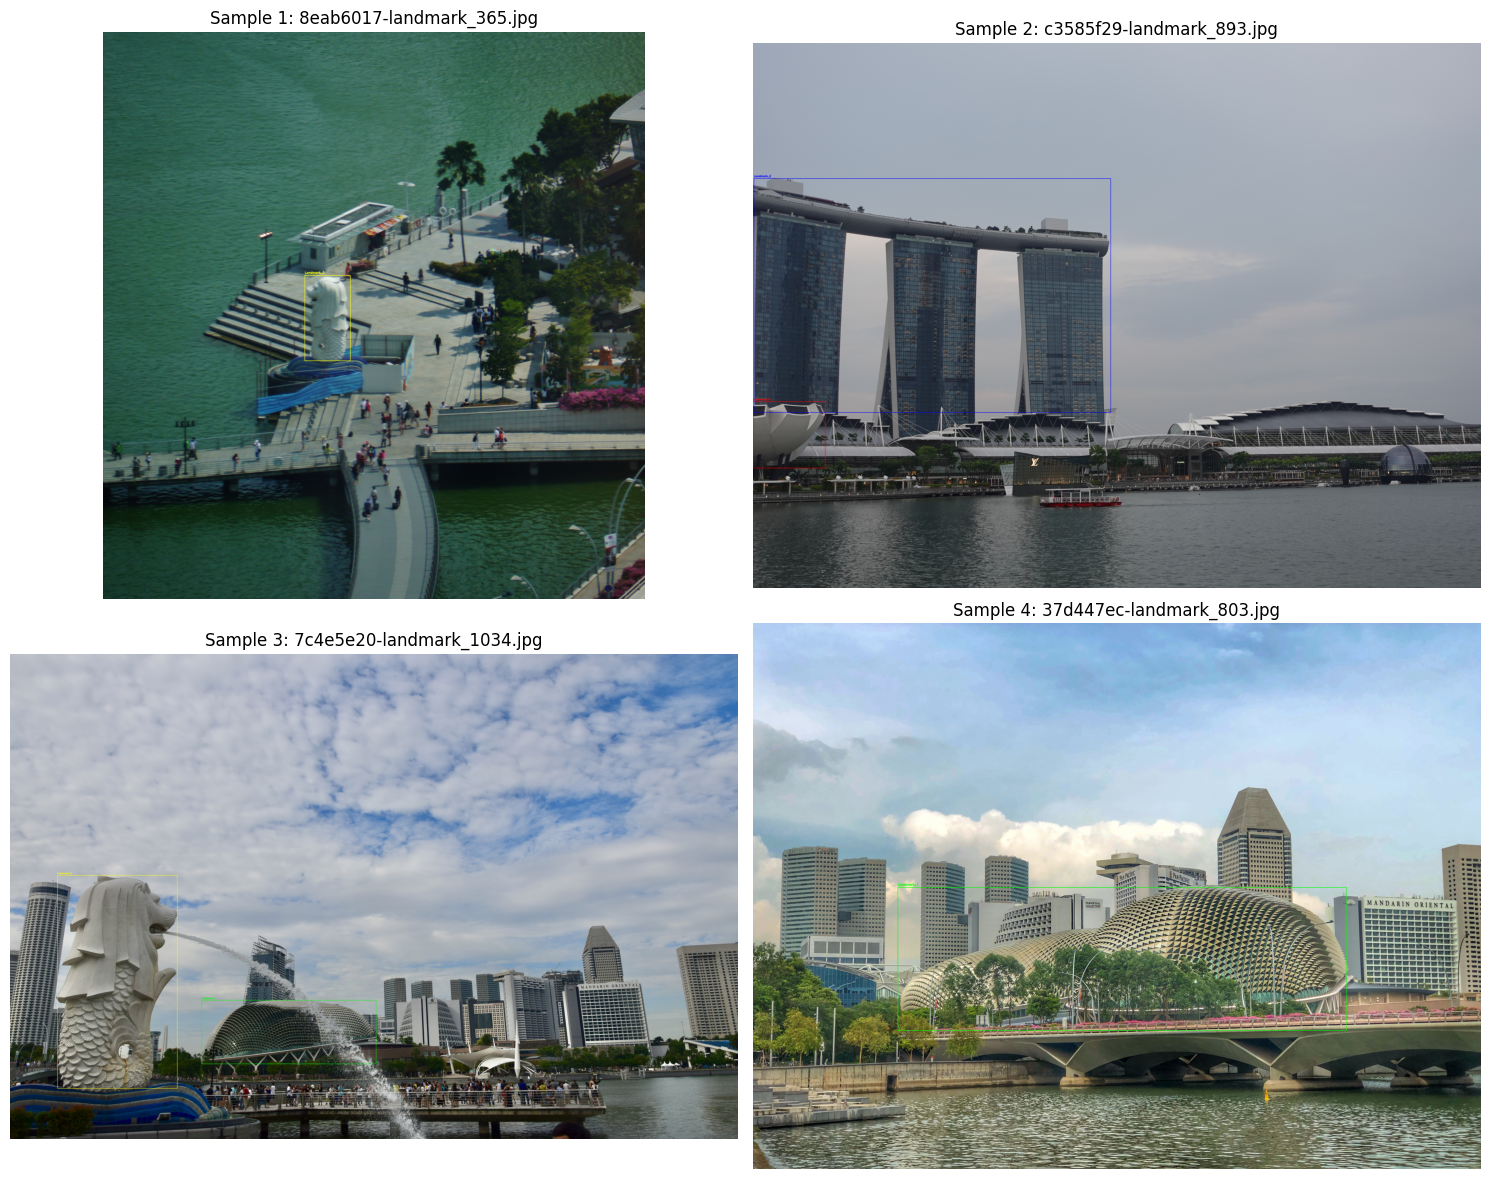


Sample visualization complete!


In [ ]:
# Cell 5: Visualize sample images with annotations
import random
import cv2
import matplotlib.pyplot as plt

from pathlib import Path
DATASET_PATH = Path(r"D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages")
IMAGES_DIR = DATASET_PATH / "images"
LABELS_DIR = DATASET_PATH / "labels"

def visualize_yolo_annotations(image_path, label_path, class_names):
    """Visualize YOLO format annotations on image"""
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Could not read image: {image_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            if line.strip():
                class_id, x_center, y_center, width, height = map(float, line.split())
                class_id = int(class_id)
                
                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                
                # Clamp coordinates to image bounds
                x1 = max(0, min(x1, w-1))
                y1 = max(0, min(y1, h-1))
                x2 = max(0, min(x2, w-1))
                y2 = max(0, min(y2, h-1))
                
                # Draw bounding box
                color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)][class_id % 4]
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                
                # Add label
                label = f"{class_names.get(class_id, f'Class {class_id}')}"
                cv2.putText(img, label, (x1, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img

# Define your class names (update these with your actual landmark names)
CLASS_NAMES = {
    0: 'Landmark_0',
    1: 'Landmark_1',
    2: 'Landmark_2',
    3: 'Landmark_3'
}

# Get all images with mixed formats
all_images = (list(IMAGES_DIR.glob("*.jpg")) + 
              list(IMAGES_DIR.glob("*.jpeg")) + 
              list(IMAGES_DIR.glob("*.png")))

print(f"Total images found: {len(all_images)}")

# Show 4 random samples
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

sample_images = random.sample(all_images, min(4, len(all_images)))

for idx, img_path in enumerate(sample_images):
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    
    if label_path.exists():
        annotated_img = visualize_yolo_annotations(img_path, label_path, CLASS_NAMES)
        if annotated_img is not None:
            axes[idx].imshow(annotated_img)
            axes[idx].set_title(f"Sample {idx+1}: {img_path.name}")
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f"No label for\n{img_path.name}", 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nSample visualization complete!")

---
## 4. Balanced Data Augmentation

Create a balanced dataset using intelligent augmentation strategies that address class imbalance while maintaining realistic landmark variations.

In [6]:
# Cell 6: IMPROVED Data Augmentation Pipeline with TRUE Class Balancing
import albumentations as A
import os
from pathlib import Path
import shutil
import math
import numpy as np
import random

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
DATASET_PATH = Path(r"D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages")
IMAGES_DIR = DATASET_PATH / "images"
LABELS_DIR = DATASET_PATH / "labels"

print("="*70)
print("IMPROVED DATA AUGMENTATION WITH TRUE CLASS BALANCING")
print("="*70)

# Create augmented dataset directory
AUGMENTED_DIR = DATASET_PATH / "augmented_images"
AUGMENTED_LABELS_DIR = DATASET_PATH / "augmented_labels"

# Clean and create directories
for directory in [AUGMENTED_DIR, AUGMENTED_LABELS_DIR]:
    if directory.exists():
        shutil.rmtree(directory)
    directory.mkdir(parents=True, exist_ok=True)

print(f"  - Images: {AUGMENTED_DIR}")
print(f"  - Labels: {AUGMENTED_LABELS_DIR}")

# STEP 1: Analyze current class distribution
print(f"\nCurrent class distribution analysis:")
total_objects = sum(class_counts.values())
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total_objects) * 100
    print(f"  Class {class_id}: {count:4d} objects ({percentage:5.1f}%)")

# STEP 2: Define TRUE balancing strategy
# Set target to the maximum class count to ensure all classes reach the same level
target_samples_per_class = max(class_counts.values())
print(f"\nTarget samples per class: {target_samples_per_class}")

# Calculate how many additional samples each class needs
samples_needed = {}
for class_id in class_counts:
    current_count = class_counts[class_id]
    needed = max(0, target_samples_per_class - current_count)
    samples_needed[class_id] = needed
    print(f"  Class {class_id}: Current {current_count:4d} → Target {target_samples_per_class:4d} (Need +{needed:3d})")

# STEP 3: Create class-specific file lists
print(f"\nBuilding class-specific image lists...")
class_image_files = {}
for class_id in class_counts:
    class_image_files[class_id] = []

# Get all original image files and categorize by class
original_images = (list(IMAGES_DIR.glob("*.jpg")) + 
                  list(IMAGES_DIR.glob("*.jpeg")) + 
                  list(IMAGES_DIR.glob("*.png")))

for img_path in original_images:
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        with open(label_path, 'r') as f:
            classes_in_image = set()
            for line in f.readlines():
                if line.strip():
                    class_id = int(line.split()[0])
                    classes_in_image.add(class_id)
            
            # Add this image to all classes that appear in it
            for class_id in classes_in_image:
                if class_id in class_image_files:
                    class_image_files[class_id].append(img_path)

print("Images available per class:")
for class_id in sorted(class_image_files.keys()):
    unique_images = len(set(class_image_files[class_id]))
    print(f"  Class {class_id}: {unique_images} unique images")

# STEP 4: Define augmentation pipelines
# Light augmentation for classes that need fewer samples
light_pipeline = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    A.GaussNoise(var_limit=(5.0, 10.0), p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.4))

# Medium augmentation for moderate imbalance
medium_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=15, p=0.5),
    A.GaussNoise(var_limit=(8.0, 20.0), p=0.3),
    A.Blur(blur_limit=2, p=0.2),
    A.Affine(scale=(0.9, 1.1), translate_percent=(-0.05, 0.05), shear=(-5, 5), p=0.4),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.4))

# Heavy augmentation for severely imbalanced classes
heavy_pipeline = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.Rotate(limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), shear=(-10, 10), p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=30, val_shift_limit=25, p=0.7),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.4),
    A.Blur(blur_limit=3, p=0.3),
    A.CLAHE(clip_limit=2.0, p=0.3),
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.4),
    A.RandomShadow(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

print(f"\nAugmentation pipelines configured:")
print("  - Light: For classes needing minimal augmentation")
print("  - Medium: For moderate imbalance") 
print("  - Heavy: For severe imbalance (minority classes)")

# STEP 5: Function definitions for YOLO label handling
def read_yolo_labels(label_path):
    """Read YOLO format labels and return as list of tuples"""
    bboxes = []
    class_labels = []
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            if line.strip():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(class_id)
    
    return bboxes, class_labels

def write_yolo_labels(label_path, bboxes, class_labels):
    """Write YOLO format labels"""
    with open(label_path, 'w') as f:
        for bbox, cls in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            f.write(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# STEP 6: Copy all original images first
print(f"\nCopying all original images to augmented dataset...")
total_copied = 0
for img_path in original_images:
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        # Copy image
        shutil.copy(img_path, AUGMENTED_DIR / img_path.name)
        # Copy label
        shutil.copy(label_path, AUGMENTED_LABELS_DIR / f"{img_path.stem}.txt")
        total_copied += 1

print(f"  Copied {total_copied} original image-label pairs")

# STEP 7: Generate class-specific augmentations to reach target balance
print(f"\nGenerating targeted augmentations for each class...")
augmentation_stats = {}
total_generated = 0

for class_id in sorted(class_counts.keys()):
    if samples_needed[class_id] == 0:
        print(f"  Class {class_id}: Already balanced, no augmentation needed")
        augmentation_stats[class_id] = 0
        continue
    
    # Determine augmentation intensity based on how many samples are needed
    ratio_needed = samples_needed[class_id] / class_counts[class_id]
    
    if ratio_needed <= 0.5:
        pipeline = light_pipeline
        aug_type = "light"
    elif ratio_needed <= 2.0:
        pipeline = medium_pipeline
        aug_type = "medium"
    else:
        pipeline = heavy_pipeline
        aug_type = "heavy"
    
    print(f"  Class {class_id}: Need {samples_needed[class_id]} more samples ({ratio_needed:.1f}x), using {aug_type} augmentation")
    
    # Get images for this class
    class_images = list(set(class_image_files[class_id]))  # Remove duplicates
    
    if len(class_images) == 0:
        print(f"    Warning: No images found for class {class_id}")
        augmentation_stats[class_id] = 0
        continue
    
    # Calculate how many augmentations per image we need
    augs_per_image = math.ceil(samples_needed[class_id] / len(class_images))
    
    generated_for_class = 0
    target_for_class = samples_needed[class_id]
    
    # Generate augmentations by cycling through available images
    for aug_round in range(augs_per_image):
        if generated_for_class >= target_for_class:
            break
        
        for img_idx, img_path in enumerate(class_images):
            if generated_for_class >= target_for_class:
                break
            
            label_path = LABELS_DIR / f"{img_path.stem}.txt"
            if not label_path.exists():
                continue
            
            # Load image and labels
            image = cv2.imread(str(img_path))
            if image is None:
                continue
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            bboxes, class_labels = read_yolo_labels(label_path)
            
            if not bboxes:
                continue
            
            # Check if this image actually contains the target class
            if class_id not in class_labels:
                continue
            
            try:
                # Apply augmentation
                augmented = pipeline(
                    image=image,
                    bboxes=bboxes,
                    class_labels=class_labels
                )
                
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_class_labels = augmented['class_labels']
                
                if not aug_bboxes:
                    continue
                
                # Check if target class is still present after augmentation
                if class_id not in aug_class_labels:
                    continue
                
                # Save augmented image and label
                aug_img_name = f"{img_path.stem}_class{class_id}_{aug_type}_aug_{aug_round}_{img_idx}.png"
                aug_img_path = AUGMENTED_DIR / aug_img_name
                
                aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(aug_img_path), aug_image_bgr)
                
                aug_label_path = AUGMENTED_LABELS_DIR / f"{img_path.stem}_class{class_id}_{aug_type}_aug_{aug_round}_{img_idx}.txt"
                write_yolo_labels(aug_label_path, aug_bboxes, aug_class_labels)
                
                generated_for_class += 1
                total_generated += 1
                
            except Exception as e:
                print(f"    Error augmenting {img_path.name}: {str(e)}")
                continue
    
    augmentation_stats[class_id] = generated_for_class
    print(f"    Generated {generated_for_class} augmentations for class {class_id}")

# STEP 8: Analyze final balanced dataset
print(f"\nAnalyzing final balanced dataset...")

# Count final class distribution
final_class_counts = Counter()
for label_file in AUGMENTED_LABELS_DIR.glob("*.txt"):
    with open(label_file, 'r') as f:
        for line in f.readlines():
            if line.strip():
                class_id = int(float(line.split()[0]))
                final_class_counts[class_id] += 1

# Count final dataset
final_images = len(list(AUGMENTED_DIR.glob("*.png")) + 
                   list(AUGMENTED_DIR.glob("*.jpg")) + 
                   list(AUGMENTED_DIR.glob("*.jpeg")))
final_labels = len(list(AUGMENTED_LABELS_DIR.glob("*.txt")))

print(f"\nDataset Expansion Summary:")
print(f"  - Original images: {len(original_images)}")
print(f"  - Final images: {final_images}")
print(f"  - Final labels: {final_labels}")
print(f"  - Total generated augmentations: {total_generated}")
print(f"  - Expansion ratio: {final_images / len(original_images):.2f}x")

print(f"\nTRUE BALANCED DATASET RESULTS:")
total_final_objects = sum(final_class_counts.values())
final_max = max(final_class_counts.values()) if final_class_counts else 0
final_min = min(final_class_counts.values()) if final_class_counts else 0

for class_id in sorted(final_class_counts.keys()):
    original_count = class_counts[class_id]
    final_count = final_class_counts[class_id]
    improvement = final_count - original_count
    percentage = (final_count / total_final_objects) * 100
    print(f"  Class {class_id}: {original_count:4d} → {final_count:4d} (+{improvement:3d}) ({percentage:5.1f}%)")

if final_max > 0 and final_min > 0:
    print(f"\nBALANCE IMPROVEMENT:")
    print(f"  Original imbalance ratio: {max_count/min_count:.2f}x")
    print(f"  Final imbalance ratio: {final_max/final_min:.2f}x") 
    print(f"  Improvement factor: {(max_count/min_count)/(final_max/final_min):.2f}x better")
    
    # Check if we achieved good balance (ratio < 1.5x is considered well-balanced)
    if final_max/final_min <= 1.5:
        print(f"  ✅ EXCELLENT BALANCE ACHIEVED!")
    elif final_max/final_min <= 2.0:
        print(f"  ✅ GOOD BALANCE ACHIEVED!")
    else:
        print(f"  ⚠️ Balance improved but could be better")

# Calculate and save optimized class weights for the balanced dataset
class_weights = {}
if total_final_objects > 0:
    n_classes = len(final_class_counts)
    
    for class_id in final_class_counts:
        weight = total_final_objects / (n_classes * final_class_counts[class_id])
        class_weights[class_id] = weight

    print(f"\nOPTIMIZED CLASS WEIGHTS FOR BALANCED DATASET:")
    for class_id in sorted(class_weights.keys()):
        print(f"  Class {class_id}: {class_weights[class_id]:.4f}")

    # Save class weights
    weights_file = DATASET_PATH / "class_weights.json"
    with open(weights_file, 'w') as f:
        json.dump(class_weights, f, indent=2)

    print(f"\nClass weights saved to: {weights_file}")

print(f"\nTRUE CLASS-BALANCED AUGMENTATION COMPLETE!")
print(f"  - Total images (original + augmented): {final_images}")
print(f"  - Total labels: {final_labels}")
print(f"  - Total generated augmentations: {total_generated}")
print(f"  - Balance achievement: {'EXCELLENT' if final_max/final_min <= 1.5 else 'GOOD' if final_max/final_min <= 2.0 else 'IMPROVED'}")

# Display augmentation statistics per class
print(f"\nAugmentation Statistics by Class:")
for class_id in sorted(augmentation_stats.keys()):
    original_count = class_counts[class_id]
    generated = augmentation_stats[class_id]
    final_count = final_class_counts.get(class_id, 0)
    print(f"  Class {class_id}: {original_count} original → +{generated} augmented → {final_count} total")

IMPROVED DATA AUGMENTATION WITH TRUE CLASS BALANCING
  - Images: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\augmented_images
  - Labels: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\augmented_labels

Current class distribution analysis:
  Class 0:  459 objects ( 30.6%)
  Class 1:  174 objects ( 11.6%)
  Class 2:  570 objects ( 38.0%)
  Class 3:  296 objects ( 19.7%)

Target samples per class: 570
  Class 2: Current  570 → Target  570 (Need +  0)
  Class 3: Current  296 → Target  570 (Need +274)
  Class 1: Current  174 → Target  570 (Need +396)
  Class 0: Current  459 → Target  570 (Need +111)

Building class-specific image lists...
Images available per class:
  Class 0: 458 unique images
  Class 1: 174 unique images
  Class 2: 570 unique images
  Class 3: 293 unique images

Augmentation pipelines configured:
  - Light: For classes needing minimal augmentation
  - Medium: For moderate imbalance
  - Heavy: For severe imbalance (

---
## 4.1 Augmentation Results Visualization

Compare original images with their augmented versions to verify the quality and effectiveness of the class balancing augmentation pipeline.

AUGMENTED_DIR exists: True
AUGMENTED_LABELS_DIR exists: True
Found 785 .png files in augmented directory
First few augmented files:
  - 00c84345-landmark_603_class3_medium_aug_0_200.png
  - 013cc3e3-landmark_54_class1_heavy_aug_0_107.png
  - 013cc3e3-landmark_54_class1_heavy_aug_1_107.png
  - 025197c8-landmark_744.png
  - 02ef3eff-landmark_453_class3_medium_aug_0_132.png

Generating original vs augmented image comparisons...
Found 1797 augmented files
Found 520 original images with augmented versions
For b4f58a15-landmark_201: found 3 augmented versions
Found 520 original images with augmented versions
For b4f58a15-landmark_201: found 3 augmented versions
For 98c78d77-landmark_510: found 3 augmented versions
For 98c78d77-landmark_510: found 3 augmented versions
For 5cdb24b5-landmark_68: found 2 augmented versions
For 5cdb24b5-landmark_68: found 2 augmented versions


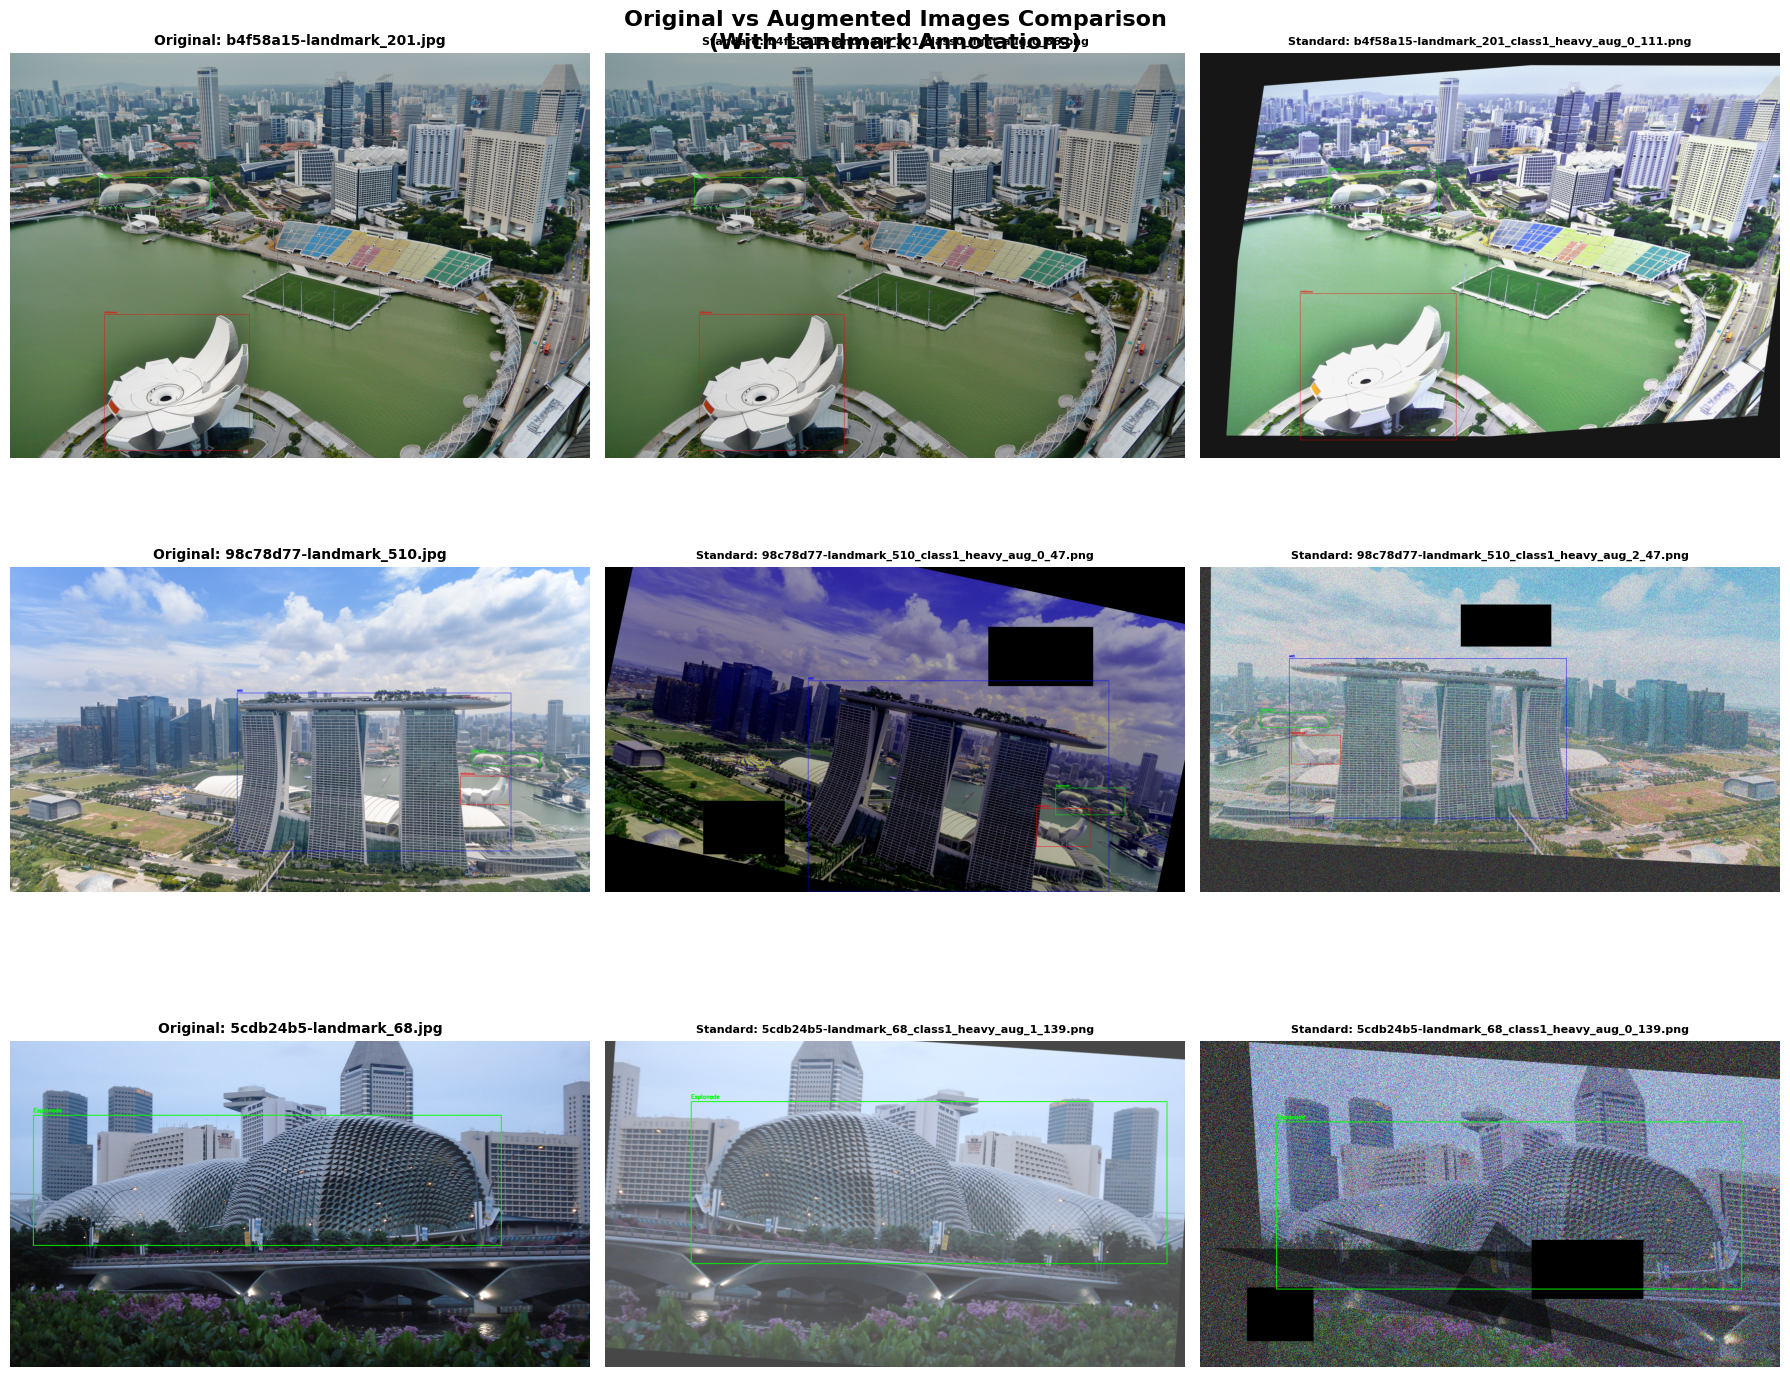


Augmentation Statistics:
  Enhanced augmentations (minority classes): 0
  Standard augmentations (majority classes): 0
  Total augmented images: 0

Class Distribution Comparison:
BEFORE Augmentation:
  Class 0:  459 objects ( 30.6%)
  Class 1:  174 objects ( 11.6%)
  Class 2:  570 objects ( 38.0%)
  Class 3:  296 objects ( 19.7%)

AFTER Augmentation:
  Class 0:  659 objects ( 24.7%) [+200]
  Class 1:  600 objects ( 22.5%) [+426]
  Class 2:  763 objects ( 28.6%) [+193]
  Class 3:  642 objects ( 24.1%) [+346]

Augmentation visualization complete!


In [13]:
# Visualize Original vs Augmented Images
import random
import matplotlib.pyplot as plt
import cv2

def compare_original_and_augmented():
    """Display side-by-side comparison of original and augmented images"""
    
    # Check if augmented directory exists and has files
    if not AUGMENTED_DIR.exists():
        print(f"Error: Augmented directory not found: {AUGMENTED_DIR}")
        return
    
    aug_files = list(AUGMENTED_DIR.glob("*.png")) + list(AUGMENTED_DIR.glob("*.jpg"))
    if len(aug_files) == 0:
        print(f"Error: No augmented files found in {AUGMENTED_DIR}")
        return
    
    print(f"Found {len(aug_files)} augmented files")
    
    # Get original images that have corresponding augmented versions
    original_images = list(IMAGES_DIR.glob("*.jpg")) + list(IMAGES_DIR.glob("*.jpeg")) + list(IMAGES_DIR.glob("*.png"))
    valid_originals = []
    
    for orig_img in original_images:
        # Look for any augmented version of this original image
        aug_pattern = f"{orig_img.stem}_*_aug_*.png"
        matching_augs = list(AUGMENTED_DIR.glob(aug_pattern))
        if len(matching_augs) > 0:
            valid_originals.append(orig_img)
    
    print(f"Found {len(valid_originals)} original images with augmented versions")
    
    if len(valid_originals) == 0:
        print("Error: No original images found with corresponding augmented versions")
        return
    
    # Select random original images
    sample_originals = random.sample(valid_originals, min(3, len(valid_originals)))
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    for row_idx, orig_img_path in enumerate(sample_originals):
        # Load original image
        orig_img = cv2.imread(str(orig_img_path))
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        orig_label_path = LABELS_DIR / f"{orig_img_path.stem}.txt"
        
        # Draw annotations on original
        annotated_orig = draw_annotations_on_image(orig_img.copy(), orig_label_path)
        
        # Display original
        axes[row_idx, 0].imshow(annotated_orig)
        axes[row_idx, 0].set_title(f"Original: {orig_img_path.name}", fontweight='bold', fontsize=10)
        axes[row_idx, 0].axis('off')
        
        # Find corresponding augmented images with better pattern matching
        aug_pattern = f"{orig_img_path.stem}_*_aug_*.png"
        aug_files = list(AUGMENTED_DIR.glob(aug_pattern))
        
        print(f"For {orig_img_path.stem}: found {len(aug_files)} augmented versions")
        
        if len(aug_files) >= 2:
            # Show 2 augmented versions
            selected_augs = random.sample(aug_files, 2)
            for col_idx, aug_img_path in enumerate(selected_augs):
                aug_img = cv2.imread(str(aug_img_path))
                if aug_img is not None:
                    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                    aug_label_path = AUGMENTED_LABELS_DIR / f"{aug_img_path.stem}.txt"
                    
                    # Draw annotations on augmented
                    annotated_aug = draw_annotations_on_image(aug_img.copy(), aug_label_path)
                    
                    axes[row_idx, col_idx + 1].imshow(annotated_aug)
                    
                    # Determine augmentation type from filename
                    aug_type = "Enhanced" if "enhanced" in aug_img_path.name else "Standard"
                    axes[row_idx, col_idx + 1].set_title(f"{aug_type}: {aug_img_path.name}", fontweight='bold', fontsize=8)
                    axes[row_idx, col_idx + 1].axis('off')
                else:
                    axes[row_idx, col_idx + 1].text(0.5, 0.5, 'Failed to Load\nAugmented Image', 
                                                   ha='center', va='center', transform=axes[row_idx, col_idx + 1].transAxes,
                                                   fontsize=10, fontweight='bold')
                    axes[row_idx, col_idx + 1].axis('off')
        elif len(aug_files) == 1:
            # Show 1 augmented version and a placeholder
            aug_img_path = aug_files[0]
            aug_img = cv2.imread(str(aug_img_path))
            if aug_img is not None:
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                aug_label_path = AUGMENTED_LABELS_DIR / f"{aug_img_path.stem}.txt"
                annotated_aug = draw_annotations_on_image(aug_img.copy(), aug_label_path)
                
                axes[row_idx, 1].imshow(annotated_aug)
                aug_type = "Enhanced" if "enhanced" in aug_img_path.name else "Standard"
                axes[row_idx, 1].set_title(f"{aug_type}: {aug_img_path.name}", fontweight='bold', fontsize=8)
                axes[row_idx, 1].axis('off')
            
            # Placeholder for second augmented image
            axes[row_idx, 2].text(0.5, 0.5, 'Only 1 Augmented\nVersion Available', 
                                 ha='center', va='center', transform=axes[row_idx, 2].transAxes,
                                 fontsize=10, fontweight='bold')
            axes[row_idx, 2].axis('off')
        else:
            # If no augmented images, show placeholders
            for col_idx in range(1, 3):
                axes[row_idx, col_idx].text(0.5, 0.5, 'No Augmented\nImage Available', 
                                           ha='center', va='center', transform=axes[row_idx, col_idx].transAxes,
                                           fontsize=10, fontweight='bold')
                axes[row_idx, col_idx].set_title(f"Augmented v{col_idx}")
                axes[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Original vs Augmented Images Comparison\n(With Landmark Annotations)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()

def draw_annotations_on_image(image, label_path):
    """Draw YOLO format annotations on image"""
    if not label_path.exists():
        return image
    
    h, w = image.shape[:2]
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    class_names = ['ArtScience', 'Esplanade', 'MBS', 'Merlion']
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            if line.strip():
                parts = line.strip().split()
                class_id = int(float(parts[0]))
                x_center, y_center, width, height = map(float, parts[1:5])
                
                # Convert to pixel coordinates
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                
                # Clamp to image bounds
                x1 = max(0, min(x1, w-1))
                y1 = max(0, min(y1, h-1))
                x2 = max(0, min(x2, w-1))
                y2 = max(0, min(y2, h-1))
                
                # Draw bounding box
                color = colors[class_id % len(colors)]
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                
                # Add class label
                label_text = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
                cv2.putText(image, label_text, (x1, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return image

# Debug information
print(f"AUGMENTED_DIR exists: {AUGMENTED_DIR.exists()}")
print(f"AUGMENTED_LABELS_DIR exists: {AUGMENTED_LABELS_DIR.exists()}")

if AUGMENTED_DIR.exists():
    aug_files = list(AUGMENTED_DIR.glob("*.png"))
    print(f"Found {len(aug_files)} .png files in augmented directory")
    if len(aug_files) > 0:
        print("First few augmented files:")
        for f in aug_files[:5]:
            print(f"  - {f.name}")

# Generate the comparison visualization
print("\nGenerating original vs augmented image comparisons...")
compare_original_and_augmented()

# Show augmentation statistics by type
if AUGMENTED_DIR.exists():
    print("\nAugmentation Statistics:")
    enhanced_files = len(list(AUGMENTED_DIR.glob("*enhanced_aug*.png")))
    standard_files = len(list(AUGMENTED_DIR.glob("*standard_aug*.png")))

    print(f"  Enhanced augmentations (minority classes): {enhanced_files}")
    print(f"  Standard augmentations (majority classes): {standard_files}")
    print(f"  Total augmented images: {enhanced_files + standard_files}")

    # Show class distribution improvement
    print("\nClass Distribution Comparison:")
    print("BEFORE Augmentation:")
    for class_id in sorted(class_counts.keys()):
        count = class_counts[class_id]
        percentage = (count / sum(class_counts.values())) * 100
        print(f"  Class {class_id}: {count:4d} objects ({percentage:5.1f}%)")

    print("\nAFTER Augmentation:")
    for class_id in sorted(final_class_counts.keys()):
        count = final_class_counts[class_id]
        percentage = (count / sum(final_class_counts.values())) * 100
        improvement = count - class_counts[class_id]
        print(f"  Class {class_id}: {count:4d} objects ({percentage:5.1f}%) [+{improvement}]")

print("\nAugmentation visualization complete!")

---
## 5. Final Dataset Creation for Training

Create stratified train/validation/test splits from the balanced dataset and generate YOLO-compatible configuration files.

In [14]:
# Stratified Dataset Split for YOLO Training
from sklearn.model_selection import train_test_split
import shutil

print("="*70)
print("CREATING STRATIFIED TRAIN/VALIDATION/TEST SPLITS")
print("="*70)

# Create image-class mapping for stratified splitting
image_files = []
image_class_labels = []

# Analyze balanced dataset for stratification
print("Preparing stratified split based on balanced dataset...")

for img_file in AUGMENTED_DIR.glob("*"):
    if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
        label_file = AUGMENTED_LABELS_DIR / f"{img_file.stem}.txt"
        
        if label_file.exists():
            # Get primary class (first class in file)
            with open(label_file, 'r') as f:
                first_line = f.readline().strip()
                if first_line:
                    primary_class = int(float(first_line.split()[0]))
                    image_files.append(img_file)
                    image_class_labels.append(primary_class)

print(f"  Total images for splitting: {len(image_files)}")

# Split ratios
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.2, 0.1

# Stratified splits
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_files, image_class_labels, test_size=TEST_RATIO, random_state=42, stratify=image_class_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VAL_RATIO/(TRAIN_RATIO + VAL_RATIO), 
    random_state=42, stratify=y_train_val
)

print(f"\nStratified split results:")
print(f"  Training: {len(X_train)} images ({len(X_train)/len(image_files)*100:.1f}%)")
print(f"  Validation: {len(X_val)} images ({len(X_val)/len(image_files)*100:.1f}%)")
print(f"  Test: {len(X_test)} images ({len(X_test)/len(image_files)*100:.1f}%)")

# Create YOLO dataset structure
YOLO_DATASET_DIR = DATASET_PATH / "balanced_yolo_dataset"
TRAIN_IMG_DIR = YOLO_DATASET_DIR / "images" / "train"
VAL_IMG_DIR = YOLO_DATASET_DIR / "images" / "val" 
TEST_IMG_DIR = YOLO_DATASET_DIR / "images" / "test"
TRAIN_LABEL_DIR = YOLO_DATASET_DIR / "labels" / "train"
VAL_LABEL_DIR = YOLO_DATASET_DIR / "labels" / "val"
TEST_LABEL_DIR = YOLO_DATASET_DIR / "labels" / "test"

# Create directories
for directory in [TRAIN_IMG_DIR, VAL_IMG_DIR, TEST_IMG_DIR, TRAIN_LABEL_DIR, VAL_LABEL_DIR, TEST_LABEL_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"\nCreated YOLO dataset structure at: {YOLO_DATASET_DIR}")

def copy_split_files_with_tracking(file_list, img_dest_dir, label_dest_dir, split_name):
    """Copy files and track class distribution"""
    class_counts = Counter()
    for img_file in file_list:
        label_file = AUGMENTED_LABELS_DIR / f"{img_file.stem}.txt"
        shutil.copy(img_file, img_dest_dir / img_file.name)
        if label_file.exists():
            shutil.copy(label_file, label_dest_dir / f"{img_file.stem}.txt")
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    if line.strip():
                        class_id = int(float(line.split()[0]))
                        class_counts[class_id] += 1
    
    total_objects = sum(class_counts.values())
    print(f"  {split_name} set: {len(file_list)} images, {total_objects} objects")
    for class_id in sorted(class_counts.keys()):
        count = class_counts[class_id]
        percentage = (count / total_objects) * 100 if total_objects > 0 else 0
        print(f"    Class {class_id}: {count:4d} objects ({percentage:5.1f}%)")
    return class_counts

# Copy files to splits
print(f"\nCopying files to train/val/test directories...")
train_counts = copy_split_files_with_tracking(X_train, TRAIN_IMG_DIR, TRAIN_LABEL_DIR, "Training")
val_counts = copy_split_files_with_tracking(X_val, VAL_IMG_DIR, VAL_LABEL_DIR, "Validation")
test_counts = copy_split_files_with_tracking(X_test, TEST_IMG_DIR, TEST_LABEL_DIR, "Test")

# Calculate final class weights for training
final_class_weights = {}
total_train_samples = sum(train_counts.values())
n_classes = len(train_counts)

print(f"\nOPTIMIZED CLASS WEIGHTS FOR TRAINING:")
for class_id in sorted(train_counts.keys()):
    weight = total_train_samples / (n_classes * train_counts[class_id])
    final_class_weights[class_id] = weight
    print(f"  Class {class_id}: {weight:.4f}")

# Create YOLO configuration
dataset_yaml_content = f"""# Balanced Landmark Detection Dataset
path: {str(YOLO_DATASET_DIR.absolute())}
train: images/train
val: images/val
test: images/test

# Classes
nc: {len(final_class_weights)}
names:
  0: ArtScience Museum
  1: Esplanade
  2: Marina Bay Sands
  3: Merlion

# Optimized class weights (use in training)
class_weights: {final_class_weights}
"""

# Save configuration files
yaml_path = YOLO_DATASET_DIR / "dataset.yaml"
with open(yaml_path, 'w') as f:
    f.write(dataset_yaml_content)

weights_path = DATASET_PATH / "class_weights.json"
with open(weights_path, 'w') as f:
    json.dump(final_class_weights, f, indent=2)

print(f"\nConfiguration saved:")
print(f"  Dataset YAML: {yaml_path}")
print(f"  Class weights: {weights_path}")

print(f"\nBALANCED DATASET READY FOR TRAINING!")
print(f"Training dataset: {yaml_path}")
print(f"Optimized for landmark detection with balanced class representation")

CREATING STRATIFIED TRAIN/VALIDATION/TEST SPLITS
Preparing stratified split based on balanced dataset...
  Total images for splitting: 1824

Stratified split results:
  Training: 1276 images (70.0%)
  Validation: 365 images (20.0%)
  Test: 183 images (10.0%)

Created YOLO dataset structure at: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\balanced_yolo_dataset

Copying files to train/val/test directories...
  Training set: 1276 images, 1882 objects
    Class 0:  472 objects ( 25.1%)
    Class 1:  422 objects ( 22.4%)
    Class 2:  541 objects ( 28.7%)
    Class 3:  447 objects ( 23.8%)
  Training set: 1276 images, 1882 objects
    Class 0:  472 objects ( 25.1%)
    Class 1:  422 objects ( 22.4%)
    Class 2:  541 objects ( 28.7%)
    Class 3:  447 objects ( 23.8%)
  Validation set: 365 images, 525 objects
    Class 0:  127 objects ( 24.2%)
    Class 1:  119 objects ( 22.7%)
    Class 2:  149 objects ( 28.4%)
    Class 3:  130 objects ( 24.8%)
  Validation se